<a href="https://colab.research.google.com/github/PLEX-GR00T/Maze_solving_MDP/blob/main/double_q_learning_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accumulated Reward per episode/rollout (per cycle of 15):
[32, 912, 1159, 1289, 1297, 1327, 1379, 1395, 1375, 1421, 1435, 1435, 1433, 1435, 1435, 1433, 1435, 1435, 1431, 1431]
qTable:
[[  0.          71.4729628    0.           0.        ]
 [  0.          74.33125251   0.          68.46876692]
 [  0.          77.26282309   0.          71.47175779]
 [  0.           0.          80.26956214  74.33108918]
 [  0.          80.26955094  86.51630469   0.        ]
 [  0.          77.26274515   0.          83.35339707]
 [  0.          80.26943731   0.          80.26956213]
 [ 77.2625872    0.          83.35339707  77.25932581]
 [ 83.35338113   0.          89.7603125    0.        ]
 [  0.          86.51630469  93.0875       0.        ]
 [  0.          83.35339707   0.          89.7603125 ]
 [ 80.26956214   0.           0.          86.51630469]
 [ 86.51630465  93.0875       0.           0.        ]
 [ 89.7603125   96.5          0.          89.7603125 ]
 [  0.         100.           0.          93.0

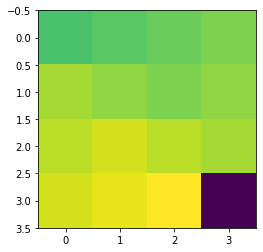

In [ ]:
 import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# connections -----------------------------------------------------------------------------------------------
# maze is 4x4 for convergence

# a1,  a2,   a3,  a4
#wall wall wall 
# a5,  a6,   a7,  a8
#      wall wall
# a9, a10,  a11, a12
#    vW     wall wall
#a13, a14,  a15, a16
#note 1 vertical wall (vW) between a9 and a13
#creating list of possible directions for each node, clockwise from north = 0, east = 1, south = 2, west = 3
#eg so for a1, you can only go east so the value is [0, 2, 0, 0] since on the east it connects to a2 and walls on all othersides
a1  = [ 0,  2,  0,  0]
a2  = [ 0,  3,  0,  1]
a3  = [ 0,  4,  0,  2]
a4  = [ 0,  0,  8,  3]
a5  = [ 0,  6,  9,  0]
a6  = [ 0,  7,  0,  5]
a7  = [ 0,  8,  0,  6]
a8  = [ 4,  0, 12,  7]
a9  = [ 5,  0, 13,  0]
a10 = [ 0, 11, 14,  0]
a11 = [ 0, 12,  0, 10]
a12 = [ 8,  0,  0, 11]
a13 = [ 9, 14,  0,  0]
a14 = [10, 15,  0, 13]
a15 = [ 0, 16,  0, 14]
a16 = [ 0,  0,  0, 15]
connections = [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15, a16]
#------------------------------------------------------------------------------------------------------------

#Settings ---------------------------------------------------------------------------------------------------
total_episodes = 100           # Total episodes
learning_rate = 0.7            # Learning rate
max_steps = 100                # Max steps per episode
gamma = 0.975                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.1              # Exponential decay rate for exploration prob

#reward
reward_normal = -1
reward_goal = 100
#------------------------------------------------------------------------------------------------------------

# stored variables ------------------------------------------------------------------------------------------
total_reward_by_cycle = []
epsilon_list = []
qtable = np.zeros((16, 4))
qtable2 = np.zeros((16, 4))
#------------------------------------------------------------------------------------------------------------


#takes in a node number and qtable and returns:
#1 the q-value of next node, either by exploration or exploitation
#2 the reward of next node
#3 next node number
#4 current node
#5 policy from current node (0 = north, 1 = east, 2 = south, 3 = west)
#note we do NOT reduce epsilon here
#node number given should already be adjusted from 0 instead of 1
#note that the connections need to be reduced by 1 to get zeroth order
def explore_or_exploit(node_number, which_table):
    current_connections = connections[node_number]
    cleaned_connections = []
    index_i = 0
    for i in current_connections:
        if (i==0):
            pass
            #do nothing
        else:
            #here we grab the none zero values (none walls) and record index (direction) as well
            #note that we reduce index by -1 to go from zeroth index
            cleaned_connections.append([i-1,index_i])
        index_i=index_i+1
        
    ## First we randomize a number
    exp_exp_tradeoff = random.uniform(0, 1)
        
    ## If this less than epsilon(exporation factor), we explore
    if exp_exp_tradeoff < epsilon:
        connected_array = random.choice(cleaned_connections)
        reward = reward_normal if connected_array[0] != 15 else reward_goal
        next_node = connected_array[0]
        value = qtable[node_number][connected_array[1]] if which_table == 0 else qtable2[node_number][connected_array[1]]
        policy_from_current = connected_array[1]
    ## otherwise we exploit
    else:
        #none zero connections adjusted for 0th indexing (-1)
        current_max = -1000
        max_array_list = []
        for i in cleaned_connections:
            qvalue_current = qtable[node_number][i[1]] if which_table == 0 else qtable2[node_number][i[1]]
            if (qvalue_current > current_max):
                max_array_list.append(i)
                current_max = qvalue_current
        max_move = max_array_list[-1]
        max_qvalue = current_max
        policy_from_current = max_move[1]
        reward = reward_normal if max_move[0] != 15 else reward_goal
        next_node = max_move[0]
        value = max_qvalue
    return [value, reward, next_node, node_number, policy_from_current]

#takes in a node number and qtable and returns:
#1 the q-value of next node, either by exploration or exploitation
#2 the reward of next node
#3 next node number
#4 current node
#5 policy from current node (0 = north, 1 = east, 2 = south, 3 = west)
#node number given should already be adjusted from 0 instead of 1
#note that the connections need to be reduced by 1 to get zeroth order
def qmax_only(node_number, which_table):
    current_connections = connections[node_number]
    cleaned_connections = []
    index_i = 0
    for i in current_connections:
        if (i==0):
            pass
            #do nothing
        else:
            #here we grab the none zero values (none walls) and record index (direction) as well
            #note that we reduce index by -1 to go from zeroth index
            cleaned_connections.append([i-1,index_i])
        index_i=index_i+1
        
    ## First we randomize a number
    exp_exp_tradeoff = random.uniform(0, 1)
        
    #none zero connections adjusted for 0th indexing (-1)
    current_max = -1000
    max_array_list = []
    for i in cleaned_connections:
        qvalue_current = qtable[node_number][i[1]] if which_table == 0 else qtable2[node_number][i[1]]
        if (qvalue_current > current_max):
            max_array_list.append(i)
            current_max = qvalue_current
    max_move = max_array_list[-1]
    max_qvalue = current_max
    policy_from_current = max_move[1]
    reward = reward_normal if max_move[0] != 15 else reward_goal
    next_node = max_move[0]
    value = max_qvalue
    return [value, reward, next_node, node_number, policy_from_current]

def reduce_epsilon(epsilon):
    if epsilon < min_epsilon:
        epsilon = epsilon - decay_rate

"""
3 loops
first loop = number of cycles
reduce epsilon after 1 cycle
2nd loop goes from 0-14 as we want to start at random spots instead of just at beginning
inner loop (3rd) we run an interation
in the inner loop we loop
start at next node = 0
update q and get next node
keep cycling
while next node != 15 (goal) keep running
break if above max steps
"""
# x cycles of 15
epsilon_list.append(epsilon)
for runs in range (1,21):
    # 1 cycle of 15
    cycle_reward_count = 0
    for c in range(0, 15):
        reward_count = 0
        current_steps = 0
        current_node = 0
        next_node = c
        while next_node < 15:
            current_node = next_node
            
            #roll for which qtable
            current_table = random.getrandbits(1)
            opposite_table = 0 if current_table == 1 else 1

            #make move
            #return [0value, 1reward, 2next_node, 3node_number, 4policy_from_current]
            next_move = explore_or_exploit(current_node, current_table)
    
            #move after next move
            #use opposite table for double q learning
            next_next_move = qmax_only(next_move[2], opposite_table)
    
            state = current_node
            action = next_move[4]
            reward = next_move[1]
            next_next_q_value = next_next_move[0]

            #q learning
            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            # qtable[new_state,:] : all the actions we can take from new state
            #qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * next_next_q_value - qtable[state, action])

            #double Q
            # random 1 of the two
            # Qa = Qa + lr[R(s,a) + gamma * max Qb' - Qa]
            # Qb = Qb + lr[R(s,a) + gamma * max Qa' - Qb]
            if current_table == 0:
              qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * next_next_q_value - qtable[state, action])
            else:
              qtable2[state, action] = qtable2[state, action] + learning_rate * (reward + gamma * next_next_q_value - qtable2[state, action])

            #update reward, steps and move to next node
            reward_count = reward_count + reward
            current_steps = current_steps + 1
            next_node = next_move[2]

            if current_steps >= max_steps:
                break 
        cycle_reward_count = cycle_reward_count + reward_count
    #update epsilon
    epsilon = epsilon - decay_rate
    if (epsilon < min_epsilon):
        epsilon = min_epsilon
    
    #update rewards
    total_reward_by_cycle.append(cycle_reward_count)
    epsilon_list.append(epsilon)
print("Accumulated Reward per episode/rollout (per cycle of 15):")
print(total_reward_by_cycle)
print("epsilon over episode:")
print(epsilon_list)
print("qTable:")
print(qtable)
print("qTable2:")
print(qtable2)

plt.imshow(np.max(qtable, axis = 1).reshape(4,4))

# fig = plt.figure(figsize=(1, 2))
# columns = 1
# rows = 2
# for i in range(1, columns*rows+1):
#     img = np.max(qtable, axis = 1).reshape(4,4) if i == 2 else  np.max(qtable2, axis = 1).reshape(4,4)
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
# plt.show()



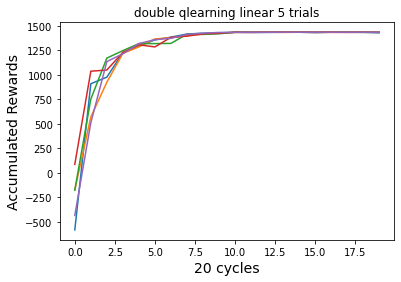

In [ ]:
#Graphic for 5 trials
plt.plot([-584, 909, 976, 1227, 1293, 1357, 1385, 1417, 1425, 1429, 1435, 1433, 1433, 1435, 1435, 1431, 1435, 1435, 1435, 1429])
plt.plot([-176, 569, 924, 1219, 1285, 1367, 1379, 1401, 1415, 1425, 1433, 1435, 1435, 1433, 1435, 1433, 1433, 1435, 1435, 1433])
plt.plot([-178, 752, 1171, 1247, 1319, 1319, 1321, 1415, 1413, 1419, 1435, 1435, 1435, 1435, 1435, 1435, 1435, 1435, 1433, 1435])
plt.plot([86, 1037, 1049, 1229, 1307, 1285, 1383, 1395, 1419, 1425, 1435, 1433, 1435, 1435, 1435, 1435, 1435, 1433, 1435, 1435])
plt.plot([-436, 510, 1135, 1215, 1319, 1359, 1373, 1413, 1425, 1433, 1433, 1435, 1435, 1435, 1435, 1435, 1435, 1435, 1435, 1435])            
plt.title('double qlearning linear 5 trials')
plt.xlabel('20 cycles', fontsize=14)
plt.ylabel('Accumulated Rewards', fontsize=14)
plt.show()